In [62]:
import numpy as np
from numpy import dot
import matplotlib.pyplot as plt
import math

import sympy
from IPython.display import display

def randn():
    return np.random.randn()


In [63]:
#################################################
#######  Simple Linear Kalman filter...
################################################

class KALMAN_FILTER:
    def __init__(self,A,H, P = None,Q= None,R= None,B= None,U= None,X= None   ):
        ### initial values 
        
        self.n = A.shape[1]
        
        self.A = A
        self.H = H
        
        self.P =  P if(P is not None) else np.eye(self.n)   
        self.Q =  Q if(Q is not None) else np.eye(self.n)  
        self.R =  R if(R is not None) else np.eye(self.n)  
        self.B = B if(B is not None) else 0
        self.U = U if(U is not None) else 0
        self.X = X if(X is not None) else np.zeros((self.n, 1)) 
        
    
            
    
    def prediction(self):
        ##################
        X = self.X
        P = self.P
        A= self.A
        Q= self.Q 
        B= self.B 
        U= self.U

        ################3#


        
        self.X = np.dot(A, X) + np.dot(B, U)
        self.P = np.dot(A, np.dot(P, A.T)) + Q
        
        return self.X
        
    
    def updation(self,Y):
        
        #################
        X = self.X
        
        P = self.P
        H = self.H
        R = self.R       
        ################
        
        if(Y.shape != np.dot(H,X).shape):
            print("Error in updation, dim error")
            return
        
        V = Y - np.dot(H,X) ### innovation process
        S = np.dot(H, np.dot(P,H.T)) + R  ### measure predictive cov
        K = np.dot(P,np.dot(H.T,np.linalg.inv(S) ))
        self.X = X + np.dot(K,V)
        self.P = P - np.dot(K,np.dot(S,K.T))
        
         

In [64]:
#### Used for ball trajectory preparation,..

def rk4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply to 
      compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

def fx(x,t):
    return fx.vel
    
def fy(y,t):
    return fy.vel - 9.8*t


class BallTrajectory2D(object):
    def __init__(self, x0, y0, velocity, theta_deg=0., g=9.8, noise=[0.0, 0.0]):
        self.x = x0
        self.y = y0
        self.t = 0        
        theta = math.radians(theta_deg)
        fx.vel = math.cos(theta) * velocity
        fy.vel = math.sin(theta) * velocity        
        self.g = g
        self.noise = noise
        
        
    def step(self, dt):
        self.x = rk4(self.x, self.t, dt, fx)
        self.y = rk4(self.y, self.t, dt, fy)
        self.t += dt 


        return np.array([[self.x + randn()*self.noise[0], self.y + randn()*self.noise[1]]]).T

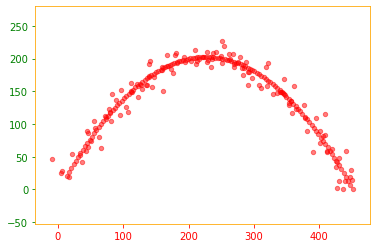

In [65]:
def test_ball_vacuum(noise):
    y = 15
    x = 10
    ball = BallTrajectory2D(x0=x, y0=y, 
                            theta_deg=60., velocity=70., 
                            noise=noise)
    t = 0
    dt = 0.1
    while y >= 0:
        meas= ball.step(dt)
        y = meas[1]

        #t += dt
        if y >= 0:
            plt.scatter(meas[0], meas[1], color='r', marker='.', s=75, alpha=0.5)
         
    plt.axis('equal');
    
test_ball_vacuum([0, 0]) # plot ideal ball position
test_ball_vacuum([10, 10]) # plot with noise 

# Ball trajectory in vaccum

In [42]:

    
def calculate_state_init(v0,x0,y0,theta):
    theta_in_rad = theta * (2*np.pi/360)
    vx = v0* np.math.cos(theta_in_rad)
    vy = v0* np.math.sin(theta_in_rad)
    return np.array([[x0,vx,y0,vy]]).T

def kf_ball_trajectory(dt,r,theta,v0,x0,y0,q):
    
    #### Initial settings...
    
    A = np.array([[1,dt,0,0],[0,1,0,0],[0,0,1,dt],[0,0,0,1]])
    ### init position using velocity and throwing position...
    X_init = calculate_state_init(v0,x0,y0,theta)
    
    ### Control input
    B = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,1]])  
    U = np.array([[0,0,0,-9.8 * dt]]).T  ### here g = 9.8 is the control input
    
    ### Measurement 
    H = np.array([[1,0,0,0],[0,0,1,0]])  ### Measuring transformation
    R = np.eye(2)*r    ### Cov of measurement noise
    
    ### Process noise can be seen as ov of weights of the filter
    ### Prediction noise cov
    Q = q*np.eye(4) 
    

    
    if(np.dot(A,X_init).shape != np.dot(B,U).shape):
        print("Errrrrroooooorrrrr, Plss checke the dimm")

    
    ### Initialisng kalman filter
    kf = KALMAN_FILTER(A = A,H = H, P = None,Q = Q, R = R,B = B,U = U,X = X_init )
    
    return kf
    


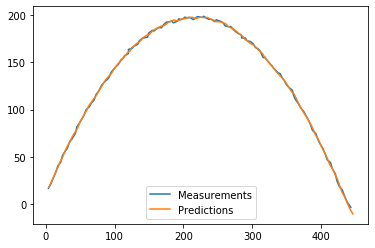

In [43]:
x0 , y0 , v0 , theta = 0,10,70,60
state_noise_ball = [1,1]
dt = 0.1
## Init filter and trajectory meas
kf = kf_ball_trajectory(dt = 0.1, r =  3, theta = theta, v0 = v0,x0 =  x0,y0 = y0,q = 1)
ball_pos = BallTrajectory2D(x0=x0, y0=y0, theta_deg=theta, velocity=v0, noise=state_noise_ball)

##### looping until ball reaches grnd . i.e; y < 0
y_meas = 0

meas_list = []
preds_list = []

while ( y_meas >= 0):
    meas = ball_pos.step(dt)
    y_meas = meas[1]

    meas_list.append(meas)
    kf.updation(meas)


    preds = np.dot(kf.H,kf.prediction())
    preds_list.append(preds)

meas_list = np.array(meas_list)
preds_list = np.array(preds_list)
plt.plot(meas_list[:,0],meas_list[:,1],label = "Measurements")
plt.plot(preds_list[:,0],preds_list[:,1], label = "Predictions")
plt.legend()

# Trajectory of ball in air

70


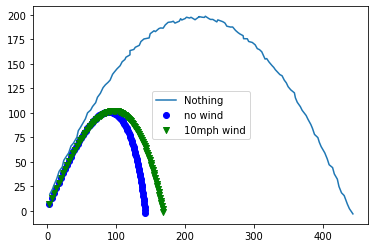

In [44]:
from math import sqrt, exp

def mph_to_mps(x):   ### miles per hour to mts per sec
    return x * .447

def drag_force(velocity):
    """ Returns the force on a baseball due to air drag at
    the specified velocity. Units are SI"""

    return velocity * ( 0.004 +  0.0058 / 
            (1. + exp((velocity-35.)/5.)))### change 0.004

#v = mph_to_mps(110.)
v = 70
print(v)
x, y = 0., 10
dt = .1
theta = np.radians(60)


def solve(x, y, vel, v_wind, launch_angle):
    xs = []
    ys = []
    v_x = vel*np.cos(launch_angle)
    v_y = vel*np.sin(launch_angle)
    while y >= 0:
        # Euler equations for x and y
        x += v_x*dt
        y += v_y*dt

        # force due to air drag    
        velocity = sqrt((v_x-v_wind)**2 + v_y**2)    
        F = drag_force(velocity)

        # euler's equations for vx and vy
        v_x = v_x - F*(v_x-v_wind)*dt
        v_y = v_y - 9.8*dt - F*v_y*dt
        
        xs.append(x)
        ys.append(y)
    
    return xs, ys
        
x, y = solve(x=0, y=1, vel=v, v_wind=0, launch_angle=theta)
p1 = plt.scatter(x, y, color='blue', label='no wind')

wind = mph_to_mps(10)
x, y = solve(x=0, y=1, vel=v, v_wind=wind, launch_angle=theta)
p2 = plt.scatter(x, y, color='green', marker="v", 
                 label='10mph wind')
plt.plot(meas_list[:,0],meas_list[:,1],label = "Nothing")
plt.legend(scatterpoints=1);



In [45]:
class BaseballPath:
    def __init__(self, x0, y0, launch_angle_deg, velocity_ms, 
                 noise=(1.0, 1.0)): 
        """ Create 2D baseball path object  
           (x = distance from start point in ground plane, 
            y=height above ground)
        
        x0,y0            initial position
        launch_angle_deg angle ball is travelling respective to 
                         ground plane
        velocity_ms      speeed of ball in meters/second
        noise            amount of noise to add to each position
                         in (x, y)
        """
        
        omega = np.radians(launch_angle_deg)
        self.v_x = velocity_ms * np.cos(omega)
        self.v_y = velocity_ms * np.sin(omega)

        self.x = x0
        self.y = y0
        self.noise = noise


    def drag_force(self, velocity):
        """ Returns the force on a baseball due to air drag at
        the specified velocity. Units are SI
        """
        B_m = 0.0039 + 0.0058 / (1. + np.exp((velocity-35.)/5.))
        return B_m * velocity


    def update(self, dt, vel_wind=0.):
        """ compute the ball position based on the specified time 
        step and wind velocity. Returns (x, y) position tuple.
        """

        # Euler equations for x and y
        self.x += self.v_x*dt
        self.y += self.v_y*dt

        # force due to air drag
        v_x_wind = self.v_x - vel_wind
        v = sqrt(v_x_wind**2 + self.v_y**2)
        F = self.drag_force(v)

        # Euler's equations for velocity
        self.v_x = self.v_x - F*v_x_wind*dt
        self.v_y = self.v_y - 9.81*dt - F*self.v_y*dt
        return np.array([[self.x + randn()*self.noise[0], self.y + randn()*self.noise[1]]]).T

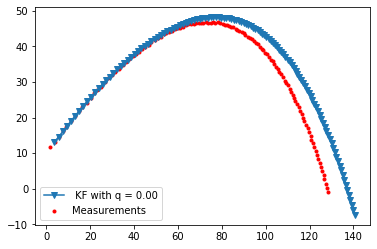

In [61]:

x0 , y0 , v0 , theta = 0,10,50,40
state_noise_ball = [.1,.1]
dt = .05
q1,q2 = 0,0

f1 = kf_ball_trajectory(dt,   .1, theta, v0 ,x0 ,y0 ,q = q1)
f2 = kf_ball_trajectory(dt = dt, r =  .3, theta = theta, v0 = v0,x0 =  x0,y0 = y0,q = q2)

ball_pos = BaseballPath(x0=x0, y0=y0, launch_angle_deg=theta, velocity_ms=v0, noise=state_noise_ball)
plt.figure()

##### looping until ball reaches grnd . i.e; y < 0
y_meas = 0

t = 0

meas_list = []
preds_list_1 = []
preds_list_2 = []

while y_meas >= 0:
    
    meas = ball_pos.update(dt)
    y_meas = meas[1]
    meas_list.append(meas)

    f1.updation(meas)
    f2.updation(meas)
    
    preds_1 = np.dot(f1.H,f1.prediction())
    preds_list_1.append(preds_1)
    
    preds_2 = np.dot(f2.H,f2.prediction())
    preds_list_2.append(preds_2)

meas_list = np.array(meas_list)
preds_list_1 = np.array(preds_list_1)
preds_list_2 = np.array(preds_list_2)

plt.scatter(meas_list[:,0],meas_list[:,1],label = "Measurements",color = 'r',marker = '.')
plt.plot(preds_list_1[:,0],preds_list_1[:,1], label = " KF with q = %.2f"%q1,marker = 'v')
#plt.plot(preds_list_2[:,0],preds_list_2[:,1], label = "KF with q = %.2f"%q2,marker = 'v')
plt.legend()

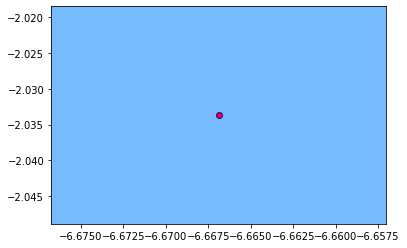

In [22]:
x1, y1 = solve(x=0, y=.1, vel=v, v_wind=0, launch_angle=theta)
plt.rcParams['axes.facecolor']='xkcd:sky blue'
p1 = plt.scatter(x1, y1, color='blue', label='no wind')

wind = mph_to_mps(10)
x2, y2 = solve(x=0, y=.1, vel=v, v_wind=wind, launch_angle=theta)
p2 = plt.scatter(x2, y2, color='r', marker="*", label='10mph wind')
#plt.legend(scatterpoints=1);
x = np.arange(-5,140)

plt.fill_between(x, -2.5, 0.1,color = '#288B22')


In [27]:

sympy.init_printing(use_latex='mathjax')

x, x_vel, y = sympy.symbols('x, x_vel ,y')

H = sympy.Matrix([sympy.sqrt(x**2 + y**2 + x_vel),x])

state = sympy.Matrix([x, x_vel, y])
J = H.jacobian(state)

display(state)
display(J)

⎡ x  ⎤
⎢    ⎥
⎢xᵥₑₗ⎥
⎢    ⎥
⎣ y  ⎦

⎡         x                     1                     y         ⎤
⎢───────────────────  ─────────────────────  ───────────────────⎥
⎢   ________________       ________________     ________________⎥
⎢  ╱  2           2       ╱  2           2     ╱  2           2 ⎥
⎢╲╱  x  + xᵥₑₗ + y    2⋅╲╱  x  + xᵥₑₗ + y    ╲╱  x  + xᵥₑₗ + y  ⎥
⎢                                                               ⎥
⎣         1                     0                     0         ⎦

In [103]:
x,v_x,y,v_y,dt = sympy.symbols(' x , v_x , y , v_y ,dt')
v = sympy.sqrt(v_x**2 + v_y**2)
F = ( (0.0058/(1+sympy.exp( (v-35)/5 ) ) ))

a1 = x+v_x*dt
a2 = v_x - F*(v_x)*dt
a3 = y + v_y*dt
a4 = v_y - 9.8*dt - F*(v_y)*dt

H = sympy.Matrix([ a1, a2, a3, a4])
state = sympy.Matrix([x,v_x,y,v_y])

J = H.jacobian(state)
v = sympy.symbols('v')
J = J.subs(sympy.sqrt(v_x**2 + v_y**2), v)

subs_value = {dt:0,v_x : 0, v_y:0, v : 0 }
print(subs_value)
A = J.evalf(subs= subs_value)

ans = np.array(A).astype(float)
print(ans)

{dt: 0, v_x: 0, v_y: 0, v: 0}
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [27]:
'''
def derive_jacobian():
    x,v_x,y,v_y,t = sympy.symbols(' x , v_x , y , v_y ,dt ')
    v = sympy.sqrt(v_x**2 + v_y**2)
    F = ( (0.0058/(1+sympy.exp( (v-35)/5 ) ) ))

    a1 = x+v_x*t
    a2 = v_x - F*(v_x)*t
    a3 = y + v_y*t
    a4 = v_y - 9.8*t - F*(v_y)*t

    H = sympy.Matrix([ a1, a2, a3, a4])
    state = sympy.Matrix([x,v_x,y,v_y])

    J = H.jacobian(state)
    #v = sympy.symbols('v')
    #J = J.subs(sympy.sqrt(v_x**2 + v_y**2), v)

    display(J)
    return J


    
def calculate_jacobian(J_obj,X,dt_value):

    
    v_value = (X.item(1)**2 + X.item(3)**2 )**0.5   ### Finding v
    subs_value = {x:0,y:0,t:0,v_x : 0,v_y:0, v: 0 }      ### dictionary of substituents
    print(subs_value)
    print(subs_value)
    subs_value[dt] = dt_value
    subs_value[v_x] = X.item(1)  ### v_x
    subs_value[v_y] = X.item(3)  ### v_y
    subs_value[v] = v_value
    J_val = J_obj.evalf(subs = subs_value)          ### evaluation
    J_val = np.array(J_val).astype(float)
    return J_val
    
    
X = np.array([[1,2,3,4]]).T
J_obj = derive_jacobian()
A = calculate_jacobian(J_obj,X,5)
print(A)

'''

def build_jacobian(X,dt_value):
    x,v_x,y,v_y,t = sympy.symbols(' x , v_x , y , v_y ,dt ')
    v = sympy.sqrt(v_x**2 + v_y**2)
    F = ( (0.0058/(1+sympy.exp( (v-35)/5 ) ) ))

    a1 = x+v_x*t
    a2 = v_x - F*(v_x)*t
    a3 = y + v_y*t
    a4 = v_y - 9.8*t - F*(v_y)*t

    H = sympy.Matrix([ a1, a2, a3, a4])
    state = sympy.Matrix([x,v_x,y,v_y])

    J = H.jacobian(state)
    
    
    v_value = (X.item(1)**2 + X.item(3)**2 )**0.5   ### Finding v
    subs_value = {t:0,v_x : 0,v_y:0 }      ### dictionary of substituents

    subs_value[t] = dt_value
    subs_value[v_x] = X.item(1)  ### v_x
    subs_value[v_y] = X.item(3)  ### v_y
    
    print(subs_value)
    J_val = J.evalf(subs = subs_value)          ### evaluation
    J_val = np.array(J_val).astype(float)
    return J_val
    
    
'''
X = np.array([[1,2,3,4]]).T
J_obj = derive_jacobian()
A = calculate_jacobian(J_obj,X,5)
'''
for k in [1,2,3]:
    
    X = np.array([[1,200,3,4]]).T
    A = build_jacobian(X,5)
    print(A)

{dt: 5, v_x: 200, v_y: 4}
[[1.00000000e+00 5.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 1.07203566e-16]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 5.00000000e+00]
 [0.00000000e+00 1.07203566e-16 0.00000000e+00 1.00000000e+00]]
{dt: 5, v_x: 200, v_y: 4}
[[1.00000000e+00 5.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 1.07203566e-16]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 5.00000000e+00]
 [0.00000000e+00 1.07203566e-16 0.00000000e+00 1.00000000e+00]]
{dt: 5, v_x: 200, v_y: 4}
[[1.00000000e+00 5.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 1.07203566e-16]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 5.00000000e+00]
 [0.00000000e+00 1.07203566e-16 0.00000000e+00 1.00000000e+00]]


In [26]:
import sympy
from IPython.display import display
sympy.init_printing(use_latex='mathjax')

x, x_vel, y = sympy.symbols('x, x_vel ,y')

H = sympy.Matrix([sympy.sqrt(x**2 + y**2 + x_vel),x])

state = sympy.Matrix([x, x_vel, y])
J = H.jacobian(state)

display(state)
display(J)


J = J.evalf(subs={x:1, x_vel:1, y:1})
ans = np.array(J).astype(float)
print(ans)

⎡ x  ⎤
⎢    ⎥
⎢xᵥₑₗ⎥
⎢    ⎥
⎣ y  ⎦

⎡         x                     1                     y         ⎤
⎢───────────────────  ─────────────────────  ───────────────────⎥
⎢   ________________       ________________     ________________⎥
⎢  ╱  2           2       ╱  2           2     ╱  2           2 ⎥
⎢╲╱  x  + xᵥₑₗ + y    2⋅╲╱  x  + xᵥₑₗ + y    ╲╱  x  + xᵥₑₗ + y  ⎥
⎢                                                               ⎥
⎣         1                     0                     0         ⎦

[[0.57735027 0.28867513 0.57735027]
 [1.         0.         0.        ]]


# Extended kalman filter

In [73]:
#################################################
#######  Extended Kalman filter...  Trial 1
################################################

class Extended_KALMAN_FILTER:
    def __init__(self,A,H,dt, P = None,Q= None,R= None,X= None   ):
        ### initial values 
        
        self.n = A.shape[1]
        
        self.A = A
        self.H = H
        
        self.P =  P if(P is not None) else np.eye(self.n)   
        self.Q =  Q if(Q is not None) else np.eye(self.n)  
        self.R =  R if(R is not None) else np.eye(self.n)  

        self.X = X if(X is not None) else np.zeros((self.n, 1)) 
        self.dt = dt
        
        
        def derive_jacobian():
            x,v_x,y,v_y,dt = sympy.symbols(' x , v_x , y , v_y ,dt')
            v = sympy.sqrt(v_x**2 + v_y**2)
            F = ( (0.0058/(1+sympy.exp( (v-35)/5 ) ) ))

            a1 = x+v_x*dt
            a2 = v_x - F*(v_x)*dt
            a3 = y + v_y*dt
            a4 = v_y - 9.8*dt - F*(v_y)*dt

            H = sympy.Matrix([ a1, a2, a3, a4])
            state = sympy.Matrix([x,v_x,y,v_y])

            J = H.jacobian(state)
            v = sympy.symbols('v')
            J = J.subs(sympy.sqrt(v_x**2 + v_y**2), v)

            #display(J)
            return J
        
        self.J_obj = derive_jacobian()
        

        
        
        
        
        
    
            
    
    def prediction(self):
        
        
        
        def calculate_jacobian(X,dt_value):   #### To calculate A for every iteration...
            
            J_obj = derive_jacobian()
            v_value = (X.item(1)**2 + X.item(3)**2 )**0.5   ### Finding v
            subs_value = {dt:0,v_x : 0, v_y:0, v : 0 }      ### dictionary of substituents
            
            
            subs_value[dt] = self.dt
            subs_value[v_x] = X.item(1)  ### v_x
            subs_value[v_y] = X.item(3)  ### v_y
            subs_value[v] = v_value
            
            
    

            print("S1")
            print(subs_value)
            
            J_val = J_obj.evalf(subs = subs_value)          ### evaluation
            print("S2")
            J_val = np.array(J_val).astype(float)
            print(J_val)
            return J_val
        
        ##################
        X = self.X
        P = self.P
        print("X")
        J_obj = self.J_obj
        A = calculate_jacobian(X,self.dt)
        print("A done")
        
        ### A missing should be given ... the jacobian matrix..
        ### Compiting jacobian using X: A
        
        

        
        
        Q= self.Q 
        dt = self.dt
        ################3#
        
        dX = dt* np.array([X[1],-1*F*X[1],X[3],-1*F*X[3]-9.8 ])
        dX = dX.reshape(X.shape)
        
        
        #self.X = np.dot(A, X) + np.dot(B, U)
        self.X = X + dX
        print("X done")
        self.P = np.dot(A, np.dot(P, A.T)) + Q
        
        print("P done")
        return self.X
        
    
    def updation(self,Y):
        
        #################
        X = self.X
        
        P = self.P
        H = self.H
        R = self.R       
        ################
        
        if(Y.shape != np.dot(H,X).shape):
            print("Error in updation, dim error")
            return
        
        V = Y - np.dot(H,X) ### innovation process
        S = np.dot(H, np.dot(P,H.T)) + R  ### measure predictive cov
        K = np.dot(P,np.dot(H.T,np.linalg.inv(S) ))
        self.X = X + np.dot(K,V)
        print("updated")
        self.P = P - np.dot(K,np.dot(S,K.T))
        
         

In [29]:

    
def calculate_state_init(v0,x0,y0,theta):
    theta_in_rad = theta * (2*np.pi/360)
    vx = v0* np.math.cos(theta_in_rad)
    vy = v0* np.math.sin(theta_in_rad)
    return np.array([[x0,vx,y0,vy]]).T

def ekf_ball_trajectory(dt,r,theta,v0,x0,y0,q):
    
    #### Initial settings...
    
    A = np.array([[1,dt,0,0],[0,1,0,0],[0,0,1,dt],[0,0,0,1]])
    ### init position using velocity and throwing position...
    X_init = calculate_state_init(v0,x0,y0,theta)
    
    
    ### Measurement 
    H = np.array([[1,0,0,0],[0,0,1,0]])  ### Measuring transformation
    R = np.eye(2)*r    ### Cov of measurement noise
    
    ### Process noise can be seen as ov of weights of the filter
    ### Prediction noise cov
    Q = q*np.eye(4) 
    

    
    ### Initialisng kalman filter
    kf = Extended_KALMAN_FILTER(A = A,H = H, dt = dt ,P = None,Q = Q, R = R,X = X_init )
    
    return kf
    


In [34]:
x0 , y0 , v0 , theta = 0,1,5,60
state_noise_ball = [1,1]
dt = .1
## Init filter and trajectory meas
kf = ekf_ball_trajectory(dt = dt, r =  3, theta = theta, v0 = v0,x0 =  x0,y0 = y0,q = 1)
ball_pos = BallTrajectory2D(x0=x0, y0=y0, theta_deg=theta, velocity=v0, noise=state_noise_ball)

##### looping until ball reaches grnd . i.e; y < 0
y_meas = 0
step = 0
meas_list = []
preds_list = []

while ( y_meas >= 0):
    meas = ball_pos.step(dt)
    y_meas = meas[1]

    meas_list.append(meas)
    kf.updation(meas)
    step+=1
    print(step)
    #### Computing the jacobian...
    
    preds = np.dot(kf.H,kf.prediction())
    preds_list.append(preds)

meas_list = np.array(meas_list)
preds_list = np.array(preds_list)
plt.plot(meas_list[:,0],meas_list[:,1],label = "Measurements")
plt.plot(preds_list[:,0],preds_list[:,1], label = "Predictions")
plt.legend()

updated
1


NameError: free variable 'dt' referenced before assignment in enclosing scope

In [33]:
def derive_jacobian():
    x,v_x,y,v_y,t = sympy.symbols(' x , v_x , y , v_y ,dt')
    v = sympy.sqrt(v_x**2 + v_y**2)
    F = ( (0.0058/(1+sympy.exp( (v-35)/5 ) ) ))

    a1 = x+v_x*t
    a2 = v_x - F*(v_x)*t
    a3 = y + v_y*t
    a4 = v_y - 9.8*t - F*(v_y)*t

    H = sympy.Matrix([ a1, a2, a3, a4])
    state = sympy.Matrix([x,v_x,y,v_y])

    J = H.jacobian(state)
    v = sympy.symbols('v')
    J = J.subs(sympy.sqrt(v_x**2 + v_y**2), v)

    #display(J)
    return J
derive_jacobian()



def calculate_jacobian(X,dt_value):   #### To calculate A for every iteration...

    J_obj = derive_jacobian()
    v_value = (X.item(1)**2 + X.item(3)**2 )**0.5   ### Finding v
    subs_value = {t : 0,v_x : 0, v_y:0, v : 0 }      ### dictionary of substituents
    #subs_value = {}

    subs_value[t] = dt_value
    subs_value[v_x] = X.item(1)  ### v_x
    subs_value[v_y] = X.item(3)  ### v_y
    subs_value[v] = v_value

    print("S1")
    print(subs_value)

    J_val = J_obj.evalf(subs = subs_value)          ### evaluation
    print("S2")
    J_val = np.array(J_val).astype(float)
    print(J_val)
    return J_val
X = np.array([[1,2,3,4]]).T
calculate_jacobian(X,0.1)

NameError: name 't' is not defined

In [32]:
#################################################
#######  Extended Kalman filter...  Trial 2
################################################

class Extended_KALMAN_FILTER:
    def __init__(self,A,H,dt, P = None,Q= None,R= None,X= None   ):
        ### initial values 
        
        self.n = A.shape[1]
        
        self.A = A
        self.H = H
        
        self.P =  P if(P is not None) else np.eye(self.n)   
        self.Q =  Q if(Q is not None) else np.eye(self.n)  
        self.R =  R if(R is not None) else np.eye(self.n)  

        self.X = X if(X is not None) else np.zeros((self.n, 1)) 
        self.dt = dt
        
    
    def prediction(self):
           
        def build_jacobian(X,dt_value):
            x,v_x,y,v_y,t = sympy.symbols(' x , v_x , y , v_y ,dt ')
            v = sympy.sqrt(v_x**2 + v_y**2)
            F = ( (0.0058/(1+sympy.exp( (v-35)/5 ) ) ))

            a1 = x+v_x*t
            a2 = v_x - F*(v_x)*t
            a3 = y + v_y*t
            a4 = v_y - 9.8*t - F*(v_y)*t

            H = sympy.Matrix([ a1, a2, a3, a4])
            state = sympy.Matrix([x,v_x,y,v_y])

            J = H.jacobian(state)


            v_value = (X.item(1)**2 + X.item(3)**2 )**0.5   ### Finding v
            subs_value = {dt:0,v_x : 0,v_y:0 }      ### dictionary of substituents

            subs_value[dt] = dt_value
            subs_value[v_x] = X.item(1)  ### v_x
            subs_value[v_y] = X.item(3)  ### v_y

            print(subs_value)
            J_val = J.evalf(subs = subs_value)          ### evaluation
            J_val = np.array(J_val).astype(float)
            return J_val
        
        ##################
        X = self.X
        P = self.P

        A = build_jacobian(X,0.1)#####   PLSSS seee initialised dt as 0.1
        print("A done")
        
        ### A missing should be given ... the jacobian matrix..
        ### Compiting jacobian using X: A
        
        

        
        
        Q= self.Q 
        dt = self.dt
        ################3#
        
        dX = dt* np.array([X[1],-1*F*X[1],X[3],-1*F*X[3]-9.8 ])
        dX = dX.reshape(X.shape)
        
        
        #self.X = np.dot(A, X) + np.dot(B, U)
        self.X = X + dX
        print("X done")
        self.P = np.dot(A, np.dot(P, A.T)) + Q
        
        print("P done")
        return self.X
        
    
    def updation(self,Y):
        
        #################
        X = self.X
        
        P = self.P
        H = self.H
        R = self.R       
        ################
        
        if(Y.shape != np.dot(H,X).shape):
            print("Error in updation, dim error")
            return
        
        V = Y - np.dot(H,X) ### innovation process
        S = np.dot(H, np.dot(P,H.T)) + R  ### measure predictive cov
        K = np.dot(P,np.dot(H.T,np.linalg.inv(S) ))
        self.X = X + np.dot(K,V)
        print("updated")
        self.P = P - np.dot(K,np.dot(S,K.T))
        
         